# Mastering Chess Endgames w/ RL: Q-learing
Zheng LUO (21-738-901)

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

from chess_vis import * # helper functions for visualization

import pandas as pd


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## OOD Neural Network Implementation

Implement the forward-feed mechanism and the back-propagation of an one-hidden layer neural network in object oriented fashion

In [3]:
# OOD ANN implementation
class ANN: # ANN object w/ 1 hidden layer w/ 200 units by default
    
    def __init__(self, N_in = 58, N_a = 32, random_seed = None, act1 = 'Relu', act2 = 'Relu'): # constructor w/ the size of input, the size of output and random_seed as optional parameters
        self.N_h=200                ## NUMBER OF HIDDEN NODES (A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200)

        ### Random seed
        if random_seed != None:
            np.random.seed(random_seed)

        ### Xavier initialization
        self.W1 = np.random.randn(self.N_h, N_in) * np.sqrt(1 / (N_in)) # input layer, of shape (200, 58)
        self.W2 = np.random.randn(N_a, self.N_h) * np.sqrt(1 / (self.N_h)) # hidden layer, of shape (32, 200)
        

        self.b1 = np.zeros((self.N_h,)) # of size 200
        self.b2 = np.zeros((N_a,)) # of size 32

        ### Parameterize the choices of activation functions
        self.act1 = 1 if act1 == 'Relu' else 2
        self.act2 = 1 if act2 == 'Relu' else 2
        self.act2 = 3 if act2 == 'Sigmoid' else self.act2

        ### Initiate neurons and activations
        self.z1 = np.zeros((self.N_h,))
        self.a1 = np.zeros((self.N_h,))
        self.z2 = np.zeros((N_a,))
        self.a2 = np.zeros((N_a,))

    def forwardfeed(self, X):
        ## Forwardfeed
        ## input -> hidden
        self.z1 = self.W1 @ X + self.b1 # of size 200
        
        self.a1 = self.relu(self.z1) if self.act1 == 1 else self.z1

        ## hidden -> output
        self.z2 = self.W2 @ self.a1 + self.b2 # of size 32
        
        if self.act2 == 3: # sigmoid activation
            self.a2 = self.sigmoid(self.z2)
        else:
            self.a2 = self.relu(self.z2) if self.act2 == 1 else self.z2 # of size 32
        return self.a2

    def relu(self, x): # rectified linear unit activation to cope w/ vanishing gradient
        return (x > 0).astype(int) * x

    def sigmoid(self, x): # sigmoid activation function
        return 1 / (1 + np.exp(-x))

    def backpropagation(self, X, delta, a_agent, eta):
        ## Backpropagation
        ## Gradients
        dz1, dz2 = self.calc_gradient(delta, a_agent)
        
        ## Descent (update)
        self.W2[a_agent, :] = self.W2[a_agent, :] + eta * dz2  * self.a1
        self.b2[a_agent] = self.b2[a_agent] + eta * dz2

        self.W1 = self.W1 + eta * np.outer(dz1, X)
        self.b1 = self.b1 + eta * dz1

        return self.W1, self.W2

    def calc_gradient(self, delta, a_agent):
        ## Gradients
        if self.act2 == 3: # sigmoid activation
            dz2 = delta * self.sigmoid_dev(self.a2[a_agent])
        else:
            dz2 = delta * self.heavy_side(self.a2[a_agent]) if self.act2 == 1 else delta # of size 1

        dz1 = delta * self.W2[a_agent, :] * self.heavy_side(self.a1) if self.act1 == 1 else dz2 * self.W2[a_agent, :] * self.a1 # of size 200
        return dz1, dz2
    

    def heavy_side(self, x): # pseudo derivative of ReLu
        return (x > 0).astype(int)

    def sigmoid_dev(self, x): # derivative of sigmoid
        return x * (1 - x)        

    def load_weights(self, W1, W2, b1, b2): # load trained model
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1.flatten()
        self.b2 = b2.flatten()


In [4]:
# define e-greedy policy, given a list of Q-values and a scalar \epsilon
def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_class= np.shape(Qvalues)[0] # find the # of elements in the vector of Q values

    rand_values=np.random.uniform(0,1) # pick a random number from a uniform distribution of [0, 1]

    rand_a=rand_values<epsilon # bool indicator if the chosen r.v. is smaller than given epsilon w/ p = epsilon

    a= np.zeros(N_class) # prepare an output vector of size N_class

    if rand_a==True: # Random exploration

        a[np.random.randint(0,N_class)]=1 # assign 1 to a random action uniformly 

    else: # Greedy

        a[np.argmax(Qvalues)]=1 # assign 1 to the action w/ highest Q value
    
    return a.astype(bool)


## Main reinforcement learning logics

In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()


N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES (A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200)


## INITALISE YOUR NEURAL NETWORK...

nn = ANN(act2 = 'Sigmoid')


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])



### Training loop of Q-learning

In [82]:
# TRAINING LOOP BONE STRUCTURE...

# Activation function
# act1 = 'Relu'
# act2 = 'Sigmoid'

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME


    while Done==0:                           ## START THE EPISODE

        # Choose action A (w/o taking it actually)
        ## pre-action meditation
        a,_=np.where(allowed_a==1) # find allowed actions
        
        ## find Q-values
        Qvalues = nn.forwardfeed(X)
        Qvalues_of_allowed_a = Qvalues[a]

        ## Given Q-values, pick an action in an e-Greedy way
        
        a_agent = a[EpsilonGreedy_Policy(Qvalues_of_allowed_a, epsilon_f)][0] # idx of the chosen action

        q = np.copy(Qvalues[a_agent])

        # take the action A & observe
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
    
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            # Record the reward and moves taken
            R_save[n]=np.copy(R)
            N_moves_save[n]=np.copy(i)
            
            # Update Weights
            ## Compute the delta
            delta = (R - q)
            
            ## Backpropagation
            nn.backpropagation(X, delta, a_agent, eta)

            break
            
        else:
            # post-action reflection (choose the next action w/o actually taking it either)
            a_next,_=np.where(allowed_a_next==1) # find allowed actions

            # Find Qvalues
            Qvalues_next = nn.forwardfeed(X_next)

            Qvalues_of_allowed_a_next = Qvalues_next[a_next]
            a_agent_next = a_next[EpsilonGreedy_Policy(Qvalues_of_allowed_a_next, epsilon_f)][0] # idx of the chosen action

            q_new = np.max(Qvalues_next)
            
            # Update Weights
            ## Compute the delta
            delta = (R + gamma * q_new - q) # no punishment
            
            ## Backpropagation
            nn.backpropagation(X, delta, a_agent, eta)
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


    print_progress(n, N_episodes)

print_progress(None, N_episodes)

print('e-Greedy agent w/ 1QN Q-learning, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))

e-Greedy agent w/ 1QN Q-learning, Average reward: 0.86206 Number of steps:  11.23885


In [85]:
# Save trained neural network to file
pd.DataFrame(nn.W1).to_csv('Q_W1.csv') # trained w/ Q-learning and default hyperparameters for 100k episodes
pd.DataFrame(nn.W2).to_csv('Q_W2.csv')
pd.DataFrame(nn.b1).to_csv('Q_b1.csv')
pd.DataFrame(nn.b2).to_csv('Q_b2.csv')
pd.DataFrame(R_save).to_csv('Q_100k_r.csv')
pd.DataFrame(N_moves_save).to_csv('Q_100k_n.csv')

## Visualization of training results

In [6]:
# load the trained weights

nn = ANN(act2 = 'Sigmoid')

nn.W1 = pd.read_csv('Q_W1.csv').to_numpy()[:, 1:] 
nn.W2 = pd.read_csv('Q_W2.csv').to_numpy()[:, 1:]
nn.b1 = pd.read_csv('Q_b1.csv').to_numpy()[:, 1:].flatten()
nn.b2 = pd.read_csv('Q_b2.csv').to_numpy()[:, 1:].flatten()
R_save = pd.read_csv('Q_r.csv').to_numpy()[:, 1:].flatten()
N_moves_save = pd.read_csv('Q_n.csv').to_numpy()[:, 1:].flatten()

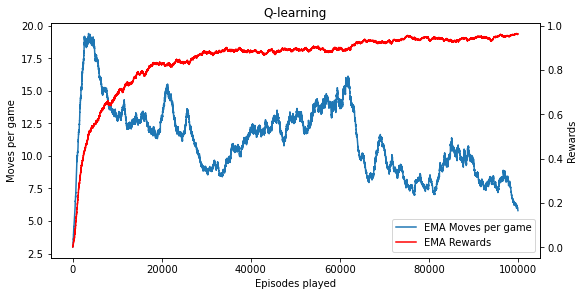

In [20]:
# plot moves per game and rewards in the same figure
fig, ax = plt.subplots(1, 1, figsize = (8, 4), constrained_layout = True)
ax_dup = ax.twinx()
er = exp_ma(N_moves_save, 2000, x_label = 'Episodes played', y_label = 'Moves per game', title = 'Q-learning', ax = ax, label = 'EMA Moves per game')
em = exp_ma(R_save, 2000, x_label = 'Episodes played', y_label = 'Rewards', ax = ax_dup, color = 'r', label = 'EMA Rewards')
fig.legend(loc=[0.67, 0.15])

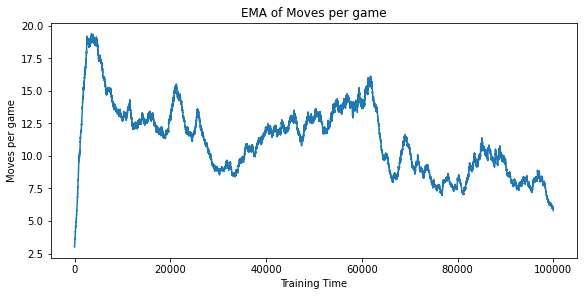

In [94]:
e = exp_ma(N_moves_save, 2000, y_label = 'Moves per game', title = 'EMA of Moves per game')

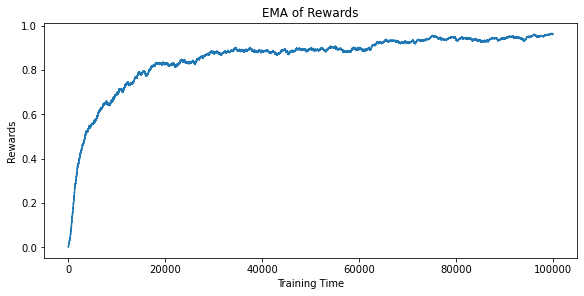

In [95]:
e = exp_ma(R_save, 2000, y_label = 'Rewards', title = 'EMA of Rewards')

### Play w/ the trained agent in a Demo case
| a 	| b 	| c 	| d 	|
|---	|---	|---	|---	|
| 0 	| 0 	| 0 	| 0 	|
| 0 	| 0 	| 0 	| 0 	|
| 1 	| 0 	| 3 	| 0 	|
| 2 	| 0 	| 0 	| 0 	|

In [7]:
# play a demo game

Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

env=Chess_Env(size_board) # reset the env

S,X,allowed_a = demo_initialise_game(env, trans('a2'), trans('a1'), trans('c2'))     ## INITIALISE A demo GAME

S_list = [np.copy(S)] # store the initial game status

# print_board(S) # print the board

while Done==0:                           ## START THE EPISODE
    
    # pre-action meditation
    
    a,_=np.where(allowed_a==1) # find allowed actions
    
    ## find Q-values
    Qvalues = nn.forwardfeed(X)
    Qvalues_of_allowed_a = Qvalues[a]

    ## Given Q-values, pick an action in a Greedy way
    
    a_agent = a[EpsilonGreedy_Policy(Qvalues_of_allowed_a, 0.001)][0] # proceed in an almost-greedy manner, w/ epsilon = 0.001 to avoid getting stuck
    

    # take an action & observe
    S,X,allowed_a,R,Done=env.OneStep(a_agent)

    # print_board(S, num = i) # print the board

    S_list.append(np.copy(S)) # record the updated game status

    
    ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
    if Done==1:

        if R == 1:
            print (f'Checkmate in {i} moves!')
        else:
            print (f'Draw in {i} moves...')
        
        break


    i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


Checkmate in 3 moves!


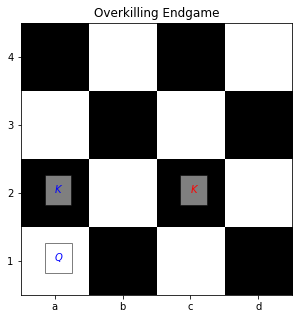

In [8]:
# visualize the initial game setup
S,X,allowed_a = demo_initialise_game(env, trans('a2'), trans('a1'), trans('c2'))
print_board(S)

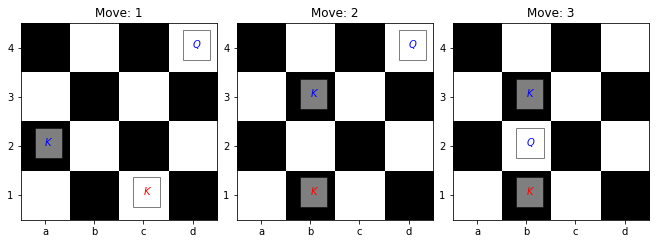

In [9]:
# visualize first 3 moves
fig, axs = plt.subplots(1, 3, figsize = (9, 4), constrained_layout = True)
for i in range(3):
    row = int(i / 3)
    col = i % 3
    print_board(S_list[i+1], i+1, ax = axs[col])